In [147]:
import numpy as np
import pandas as pd

# Read the full preprocessed data
df = pd.read_csv('preprocessed_full_data.csv')
# Read the labelled data
df_labelled = pd.read_csv('labelled_data.csv')
# Now df contains the data from the CSV file

In [149]:
len(df), len(df_labelled)

(26766, 9985)

In [150]:
df['cleaned_text'][1]

'šitāds saeima paldies visur rēgoties psrs visur komunists pats komunists palieka visur zagt pats afērists sekta viss nabags pats nabags tāls dežurants nav attīstīt paldies cilvēks vesels saprāts kas šleseristus vienkāršs pasūtīt'

In [151]:
from sklearn.utils import resample

# Separate the data into positive, neutral, and negative classes
positive_class = df_labelled[df_labelled['label'] == 1]
neutral_class = df_labelled[df_labelled['label'] == 0]
negative_class = df_labelled[df_labelled['label'] == -1]

# Resample the minority classes to match the size of the majority class (assuming -1 is the majority)
neutral_resampled = resample(neutral_class, replace=True, n_samples=len(positive_class), random_state=42)
negative_resampled = resample(negative_class, replace=True, n_samples=len(positive_class), random_state=42)

# Combine the resampled classes into a new balanced dataframe
df_labelled_balanced = pd.concat([positive_class, neutral_resampled, negative_resampled])

# Shuffle the new dataframe to mix the classes
df_labelled_balanced = df_labelled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution in the new dataframe
df_labelled_balanced['label'].value_counts()

label
 0    969
 1    969
-1    969
Name: count, dtype: int64

# Undersampled Lemmatized

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tomsb\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Average Training Loss: 0.9184
Epoch 1/5 - Time: 1569.54 seconds
Accuracy: 0.6443, Weighted Precision: 0.6745, Weighted Recall: 0.6443, Weighted F1 Score: 0.6267
Confusion Matrix:
[[160  29  13]
 [ 29 140   8]
 [ 67  61  75]]

Epoch 2/5 - Average Training Loss: 0.6944
Epoch 2/5 - Time: 1567.85 seconds
Accuracy: 0.7079, Weighted Precision: 0.7147, Weighted Recall: 0.7079, Weighted F1 Score: 0.7043
Confusion Matrix:
[[165  16  21]
 [ 29 131  17]
 [ 53  34 116]]

Epoch 3/5 - Average Training Loss: 0.5001
Epoch 3/5 - Time: 1584.56 seconds
Accuracy: 0.7045, Weighted Precision: 0.7144, Weighted Recall: 0.7045, Weighted F1 Score: 0.7010
Confusion Matrix:
[[173   5  24]
 [ 37 117  23]
 [ 55  28 120]]

Epoch 4/5 - Average Training Loss: 0.3091
Epoch 4/5 - Time: 1556.93 seconds
Accuracy: 0.7027, Weighted Precision: 0.7132, Weighted Recall: 0.7027, Weighted F1 Score: 0.6960
Confusion Matrix:
[[165  21  16]
 [ 23 139  15]
 [ 49  49 105]]

Epoch 5/5 - Average Training Loss: 0.1975
Epoch 

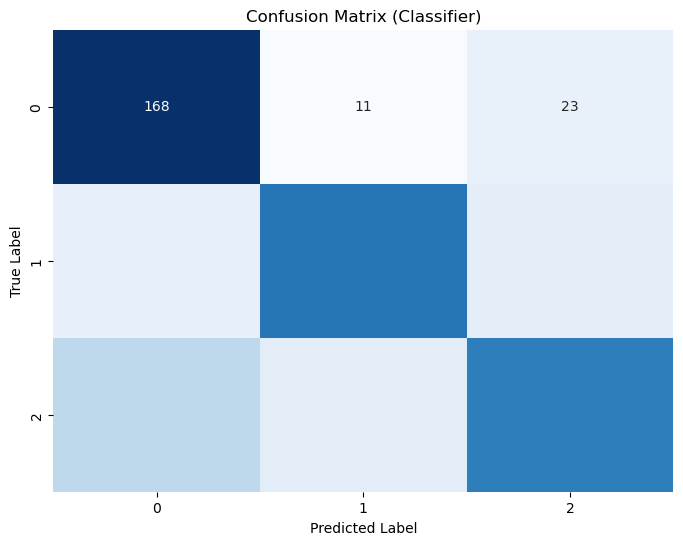

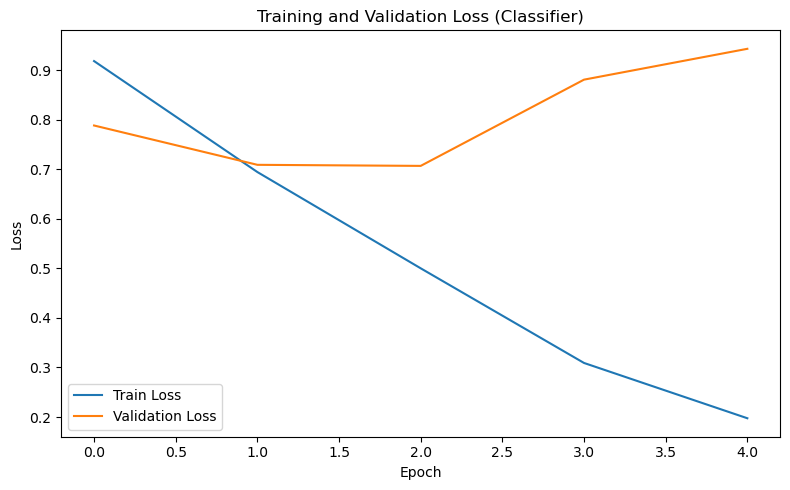

In [154]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the model name
lvbert_model_name = "AiLab-IMCS-UL/lvbert"

# Load the LvBERT model for both pretraining and classification
lvbert_model = BertForSequenceClassification.from_pretrained(lvbert_model_name)
lvbert_tokenizer = BertTokenizer.from_pretrained(lvbert_model_name)

# Load cleaned tweets
text_data = df['cleaned_text'].astype(str).tolist()

# Tokenize and encode the cleaned text for both pretraining and classification
encoded_data_lvbert = lvbert_tokenizer(text_data, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create a Dataset and DataLoader for both pretraining and classification
class LvbertDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data['input_ids'])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encoded_data.items()}

lvbert_dataset = LvbertDataset(encoded_data_lvbert)
lvbert_dataloader = DataLoader(lvbert_dataset, batch_size=32, shuffle=True)

# Define the classifier model
classifier_model_undersampled_lemmatized = BertForSequenceClassification.from_pretrained(lvbert_model_name, num_labels=3)  # Adjust the number of labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fine-tune the classifier model on the labeled dataset
classifier_model_undersampled_lemmatized.to(device)

# Split the subset into train and validation sets
df_labelled_train, df_labelled_val = train_test_split(df_labelled_balanced, test_size=0.2, random_state=42)

# Convert the cleaned_text column to a list of strings
df_labelled_train['cleaned_text'] = df_labelled_train['cleaned_text'].apply(lambda x: str(x))
df_labelled_val['cleaned_text'] = df_labelled_val['cleaned_text'].apply(lambda x: str(x))

# Tokenize and encode the cleaned text for fine-tuning
encoded_data_finetune_train = lvbert_tokenizer(df_labelled_train['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
encoded_data_finetune_val = lvbert_tokenizer(df_labelled_val['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create Datasets and DataLoaders for fine-tuning
class FineTuneDataset(Dataset):
    def __init__(self, encoded_data, labels):
        self.encoded_data = encoded_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {key: tensor[idx] for key, tensor in self.encoded_data.items()}
        sample['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long) + 1  # Adjust the label to be in the range [1, 2, 3]
        return sample

finetune_dataset_train = FineTuneDataset(encoded_data_finetune_train, df_labelled_train['label'])
finetune_dataset_val = FineTuneDataset(encoded_data_finetune_val, df_labelled_val['label'])

finetune_dataloader_train = DataLoader(finetune_dataset_train, batch_size=32, shuffle=True)
finetune_dataloader_val = DataLoader(finetune_dataset_val, batch_size=32, shuffle=False)

# Define the optimizer and loss function for fine-tuning
optimizer = AdamW(classifier_model_undersampled_lemmatized.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Fine-tune the classifier model
num_epochs = 5  # Adjust as needed

# Lists to store metrics over epochs
train_losses_undersampled_lemmatized = []
val_losses_undersampled_lemmatized = []
accuracies_undersampled_lemmatized = []
precisions_undersampled_lemmatized = []
recalls_undersampled_lemmatized = []
f1_scores_undersampled_lemmatized = []
conf_matrices_undersampled_lemmatized = []

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    classifier_model_undersampled_lemmatized.train()
    epoch_train_losses_undersampled_lemmatized = []

    for batch in finetune_dataloader_train:
        inputs = {key: tensor.to(device) for key, tensor in batch.items()}

        optimizer.zero_grad()
        outputs = classifier_model_undersampled_lemmatized(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        optimizer.step()

        epoch_train_losses_undersampled_lemmatized.append(loss.item())

    avg_train_loss_undersampled_lemmatized = sum(epoch_train_losses_undersampled_lemmatized) / len(epoch_train_losses_undersampled_lemmatized)
    train_losses_undersampled_lemmatized.append(avg_train_loss_undersampled_lemmatized)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {avg_train_loss_undersampled_lemmatized:.4f}')

    classifier_model_undersampled_lemmatized.eval()
    epoch_val_losses_undersampled_lemmatized = []
    predictions_undersampled_lemmatized = []
    true_labels_undersampled_lemmatized = []

    with torch.no_grad():
        for batch in finetune_dataloader_val:
            inputs = {key: tensor.to(device) for key, tensor in batch.items()}

            outputs = classifier_model_undersampled_lemmatized(**inputs)
            loss = criterion(outputs.logits, inputs['labels'])
            epoch_val_losses_undersampled_lemmatized.append(loss.item())

            _, predicted_labels = torch.max(outputs.logits, 1)

            predictions_undersampled_lemmatized.extend(predicted_labels.cpu().numpy())
            true_labels_undersampled_lemmatized.extend(inputs['labels'].cpu().numpy())

    avg_val_loss_undersampled_lemmatized = sum(epoch_val_losses_undersampled_lemmatized) / len(epoch_val_losses_undersampled_lemmatized)
    val_losses_undersampled_lemmatized.append(avg_val_loss_undersampled_lemmatized)

    # Calculate metrics
    accuracy_undersampled_lemmatized = accuracy_score(true_labels_undersampled_lemmatized, predictions_undersampled_lemmatized)
    accuracies_undersampled_lemmatized.append(accuracy_undersampled_lemmatized)

    precision_undersampled_lemmatized, recall_undersampled_lemmatized, f1_score_undersampled_lemmatized, _ = precision_recall_fscore_support(true_labels_undersampled_lemmatized, predictions_undersampled_lemmatized, average='weighted')
    precisions_undersampled_lemmatized.append(precision_undersampled_lemmatized)
    recalls_undersampled_lemmatized.append(recall_undersampled_lemmatized)
    f1_scores_undersampled_lemmatized.append(f1_score_undersampled_lemmatized)

    conf_matrix_undersampled_lemmatized = confusion_matrix(true_labels_undersampled_lemmatized, predictions_undersampled_lemmatized)
    conf_matrices_undersampled_lemmatized.append(conf_matrix_undersampled_lemmatized)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time:.2f} seconds')
    print(f'Accuracy: {accuracy_undersampled_lemmatized:.4f}, Weighted Precision: {precision_undersampled_lemmatized:.4f}, Weighted Recall: {recall_undersampled_lemmatized:.4f}, Weighted F1 Score: {f1_score_undersampled_lemmatized:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix_undersampled_lemmatized}\n')

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f'Total training time: {total_time:.2f} seconds')

# Save the trained classifier model
classifier_model_undersampled_lemmatized_save_path = 'undersampled_lemmatized_BERT_model'
classifier_model_undersampled_lemmatized.save_pretrained(classifier_model_undersampled_lemmatized_save_path)

# Save metrics and plots
metrics_df_undersampled_lemmatized = pd.DataFrame({
    'Train Loss': train_losses_undersampled_lemmatized,
    'Validation Loss': val_losses_undersampled_lemmatized,
    'Accuracy': accuracies_undersampled_lemmatized,
    'Weighted Precision': precisions_undersampled_lemmatized,
    'Weighted Recall': recalls_undersampled_lemmatized,
    'Weighted F1 Score': f1_scores_undersampled_lemmatized,
})

metrics_df_undersampled_lemmatized.to_csv('training_metrics_classifier_undersampled_lemmatized.csv', index=False)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices_undersampled_lemmatized[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_undersampled_lemmatized.png')  # Save confusion matrix plot as an image
plt.show()

# Plotting learning curves
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(train_losses_undersampled_lemmatized, label='Train Loss')
plt.plot(val_losses_undersampled_lemmatized, label='Validation Loss')
plt.title('Training and Validation Loss (Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_undersampled_lemmatized.png')  # Save learning curves plot as an image
plt.show()

# Oversampled Lemmatized

In [1]:
# Read the processed data
df = pd.read_csv('preprocessed_full_data.csv')
# Read the labelled data
df_labelled = pd.read_csv('labelled_data.csv')

In [2]:
len(df), len(df_labelled)

(26766, 9985)

In [3]:
from imblearn.over_sampling import RandomOverSampler

# Separate the data into features (X) and labels (y)
X = df_labelled['cleaned_text']
y = df_labelled['label']

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with resampled data
df_labelled_balanced = pd.DataFrame({'cleaned_text': X_resampled.flatten(), 'label': y_resampled})

# Shuffle the new DataFrame to mix the classes
df_labelled_balanced = df_labelled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution in the new DataFrame
df_labelled_balanced['label'].value_counts()

label
 0    6719
-1    6719
 1    6719
Name: count, dtype: int64

In [4]:
len(df), len(df_labelled)

(26766, 9985)

In [6]:
df_labelled.head()

,text,label,processed_text_latvian,tweet_length,stopwords,hashtags,user_mentions,emojis,cleaned_text
0,🎉 VĒSTURISKA UZVARA!Šodien Saeima ar 70 balsīm...,1,🎉 vēsturiska uzvara šodien saeima 70 balsīm pi...,32,0,0,0,0,vēsturisks uzvara šodien saeima balss pieņemt ...
1,Gobzems nometis visas maskas - šobrīd Saeimā ļ...,-1,gobzems nometis visas maskas šobrīd saeimā ļot...,24,0,0,0,0,gobzems nomest viss maska šobrīd saeima ļoti a...
2,Šodien Saeimas komisijā atbalstīja manus un NA...,0,šodien saeimas komisijā atbalstīja manus na pr...,30,0,0,0,0,šodien saeima komisija atbalstīt mans na priek...
3,Latvijas Republikas Saeima gala lasījumā atbal...,0,latvijas republikas saeima gala lasījumā atbal...,26,0,0,0,0,latvija republika saeima gals lasījums atbalst...
4,"""Jūlijas Stepeņenko vīrs, biedrs Vjačeslavs St...",-1,jūlijas stepeņenko vīrs biedrs vjačeslavs step...,19,0,0,1,0,vīrs biedrs stepaņenko suverēns vara mēģināt s...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tomsb\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Average Training Loss: 0.6157
Epoch 1/5 - Time: 12137.81 seconds
Accuracy: 0.8517, Weighted Precision: 0.8576, Weighted Recall: 0.8517, Weighted F1 Score: 0.8528
Confusion Matrix:
[[1161  144   44]
 [ 158 1119   20]
 [ 141   91 1154]]

Epoch 2/5 - Average Training Loss: 0.2559
Epoch 2/5 - Time: 11357.20 seconds
Accuracy: 0.9256, Weighted Precision: 0.9253, Weighted Recall: 0.9256, Weighted F1 Score: 0.9252
Confusion Matrix:
[[1185  111   53]
 [  93 1189   15]
 [  14   14 1358]]

Epoch 3/5 - Average Training Loss: 0.1220
Epoch 3/5 - Time: 12325.78 seconds
Accuracy: 0.9358, Weighted Precision: 0.9372, Weighted Recall: 0.9358, Weighted F1 Score: 0.9352
Confusion Matrix:
[[1159  150   40]
 [  53 1233   11]
 [   0    5 1381]]

Epoch 4/5 - Average Training Loss: 0.0662
Epoch 4/5 - Time: 11105.74 seconds
Accuracy: 0.9544, Weighted Precision: 0.9542, Weighted Recall: 0.9544, Weighted F1 Score: 0.9541
Confusion Matrix:
[[1250   75   24]
 [  65 1214   18]
 [   0    2 1384]]

Epoch 5/

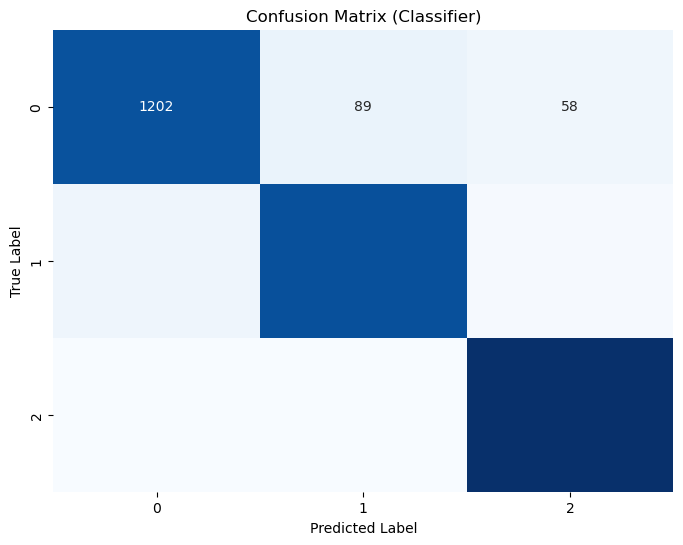

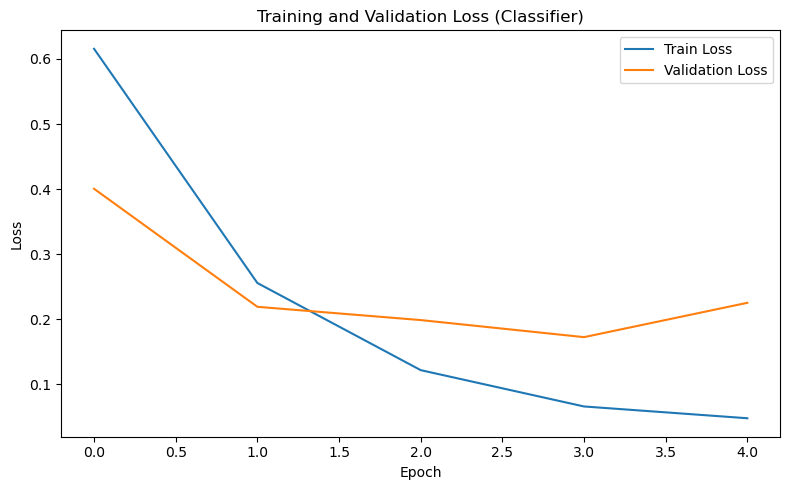

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the model name
lvbert_model_name = "AiLab-IMCS-UL/lvbert"

# Load the LvBERT model for both pretraining and classification
lvbert_model = BertForSequenceClassification.from_pretrained(lvbert_model_name)
lvbert_tokenizer = BertTokenizer.from_pretrained(lvbert_model_name)

# Convert to string cleaned text
text_data = df['cleaned_text'].astype(str).tolist()

# Tokenize and encode the cleaned text for both pretraining and classification
encoded_data_lvbert = lvbert_tokenizer(text_data, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create a Dataset and DataLoader for both pretraining and classification
class LvbertDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data['input_ids'])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encoded_data.items()}

lvbert_dataset = LvbertDataset(encoded_data_lvbert)
lvbert_dataloader = DataLoader(lvbert_dataset, batch_size=32, shuffle=True)

# Define the classifier model
classifier_model_ros_lemmatized = BertForSequenceClassification.from_pretrained(lvbert_model_name, num_labels=3)  # Adjust the number of labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fine-tune the classifier model on the labeled dataset
classifier_model_ros_lemmatized.to(device)

# Split the subset into train and validation sets
df_labelled_train, df_labelled_val = train_test_split(df_labelled_balanced, test_size=0.2, random_state=42)

# Convert the cleaned_text column to a list of strings
df_labelled_train['cleaned_text'] = df_labelled_train['cleaned_text'].apply(lambda x: str(x))
df_labelled_val['cleaned_text'] = df_labelled_val['cleaned_text'].apply(lambda x: str(x))

# Tokenize and encode the cleaned text for fine-tuning
encoded_data_finetune_train = lvbert_tokenizer(df_labelled_train['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
encoded_data_finetune_val = lvbert_tokenizer(df_labelled_val['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create Datasets and DataLoaders for fine-tuning
class FineTuneDataset(Dataset):
    def __init__(self, encoded_data, labels):
        self.encoded_data = encoded_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {key: tensor[idx] for key, tensor in self.encoded_data.items()}
        sample['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long) + 1  # Adjust the label to be in the range [1, 2, 3]
        return sample

finetune_dataset_train = FineTuneDataset(encoded_data_finetune_train, df_labelled_train['label'])
finetune_dataset_val = FineTuneDataset(encoded_data_finetune_val, df_labelled_val['label'])

finetune_dataloader_train = DataLoader(finetune_dataset_train, batch_size=32, shuffle=True)
finetune_dataloader_val = DataLoader(finetune_dataset_val, batch_size=32, shuffle=False)

# Define the optimizer and loss function for fine-tuning
optimizer = AdamW(classifier_model_ros_lemmatized.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Fine-tune the classifier model
num_epochs = 5  # Adjust as needed

# Lists to store metrics over epochs
train_losses_ros_lemmatized = []
val_losses_ros_lemmatized = []
accuracies_ros_lemmatized = []
precisions_ros_lemmatized = []
recalls_ros_lemmatized = []
f1_scores_ros_lemmatized = []
conf_matrices_ros_lemmatized = []

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    classifier_model_ros_lemmatized.train()
    epoch_train_losses_ros_lemmatized = []

    for batch in finetune_dataloader_train:
        inputs = {key: tensor.to(device) for key, tensor in batch.items()}

        optimizer.zero_grad()
        outputs = classifier_model_ros_lemmatized(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        optimizer.step()

        epoch_train_losses_ros_lemmatized.append(loss.item())

    avg_train_loss_ros_lemmatized = sum(epoch_train_losses_ros_lemmatized) / len(epoch_train_losses_ros_lemmatized)
    train_losses_ros_lemmatized.append(avg_train_loss_ros_lemmatized)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {avg_train_loss_ros_lemmatized:.4f}')

    classifier_model_ros_lemmatized.eval()
    epoch_val_losses_ros_lemmatized = []
    predictions_ros_lemmatized = []
    true_labels_ros_lemmatized = []

    with torch.no_grad():
        for batch in finetune_dataloader_val:
            inputs = {key: tensor.to(device) for key, tensor in batch.items()}

            outputs = classifier_model_ros_lemmatized(**inputs)
            loss = criterion(outputs.logits, inputs['labels'])
            epoch_val_losses_ros_lemmatized.append(loss.item())

            _, predicted_labels = torch.max(outputs.logits, 1)

            predictions_ros_lemmatized.extend(predicted_labels.cpu().numpy())
            true_labels_ros_lemmatized.extend(inputs['labels'].cpu().numpy())

    avg_val_loss_ros_lemmatized = sum(epoch_val_losses_ros_lemmatized) / len(epoch_val_losses_ros_lemmatized)
    val_losses_ros_lemmatized.append(avg_val_loss_ros_lemmatized)

    # Calculate metrics
    accuracy_ros_lemmatized = accuracy_score(true_labels_ros_lemmatized, predictions_ros_lemmatized)
    accuracies_ros_lemmatized.append(accuracy_ros_lemmatized)

    precision_ros_lemmatized, recall_ros_lemmatized, f1_score_ros_lemmatized, _ = precision_recall_fscore_support(true_labels_ros_lemmatized, predictions_ros_lemmatized, average='weighted')
    precisions_ros_lemmatized.append(precision_ros_lemmatized)
    recalls_ros_lemmatized.append(recall_ros_lemmatized)
    f1_scores_ros_lemmatized.append(f1_score_ros_lemmatized)

    conf_matrix_ros_lemmatized = confusion_matrix(true_labels_ros_lemmatized, predictions_ros_lemmatized)
    conf_matrices_ros_lemmatized.append(conf_matrix_ros_lemmatized)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time:.2f} seconds')
    print(f'Accuracy: {accuracy_ros_lemmatized:.4f}, Weighted Precision: {precision_ros_lemmatized:.4f}, Weighted Recall: {recall_ros_lemmatized:.4f}, Weighted F1 Score: {f1_score_ros_lemmatized:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix_ros_lemmatized}\n')

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f'Total training time: {total_time:.2f} seconds')

# Save the trained classifier model
classifier_model_ros_lemmatized_save_path = 'ros_lemmatized_BERT_model'
classifier_model_ros_lemmatized.save_pretrained(classifier_model_ros_lemmatized_save_path)

# Save metrics and plots
metrics_df_ros_lemmatized = pd.DataFrame({
    'Train Loss': train_losses_ros_lemmatized,
    'Validation Loss': val_losses_ros_lemmatized,
    'Accuracy': accuracies_ros_lemmatized,
    'Weighted Precision': precisions_ros_lemmatized,
    'Weighted Recall': recalls_ros_lemmatized,
    'Weighted F1 Score': f1_scores_ros_lemmatized,
})

metrics_df_ros_lemmatized.to_csv('training_metrics_classifier_ros_lemmatized.csv', index=False)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices_ros_lemmatized[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_ros_lemmatized.png')  # Save confusion matrix plot as an image
plt.show()

# Plotting learning curves
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(train_losses_ros_lemmatized, label='Train Loss')
plt.plot(val_losses_ros_lemmatized, label='Validation Loss')
plt.title('Training and Validation Loss (Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_ros_lemmatized.png')  # Save learning curves plot as an image
plt.show()

In [8]:
# Save predictions and true labels to a file
np.savez('roc_auc_bert_oversampled.npz', predictions=predictions_ros_lemmatized, true_labels=true_labels_ros_lemmatized)
np.savez('conf_matrices_ros_lemmatized.npz', conf_matrices=conf_matrices_ros_lemmatized)

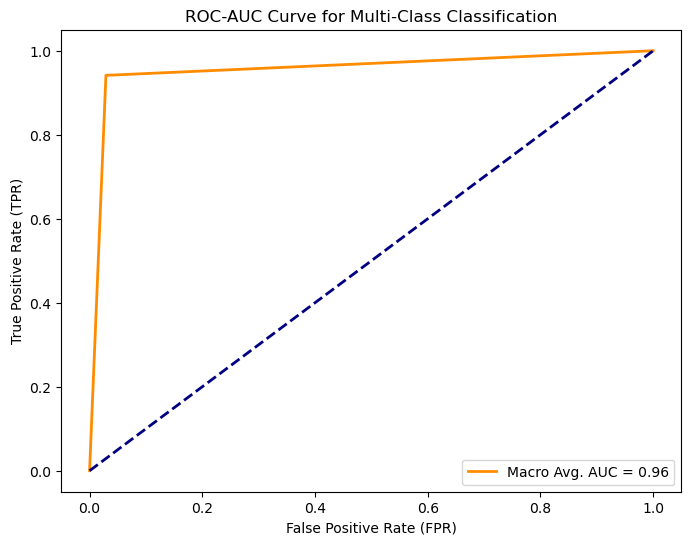

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Load predictions and true labels from the saved file
loaded_data = np.load('roc_auc_bert_oversampled.npz')
loaded_predictions = loaded_data['predictions']
loaded_true_labels = loaded_data['true_labels']

# Binarize the true labels for multi-class ROC-AUC
num_classes = len(np.unique(loaded_true_labels))
binarized_true_labels = label_binarize(loaded_true_labels, classes=np.arange(num_classes))

# Calculate ROC curve and AUC for each class (one-vs-rest)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], loaded_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate mean FPR and mean TPR
mean_fpr = np.mean([fpr[i] for i in range(num_classes)], axis=0)
mean_tpr = np.mean([tpr[i] for i in range(num_classes)], axis=0)

# Calculate macro-average ROC-AUC
roc_auc_macro = auc(mean_fpr, mean_tpr)

# Plot macro-average ROC-AUC
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Macro Avg. AUC = {roc_auc_macro:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-AUC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

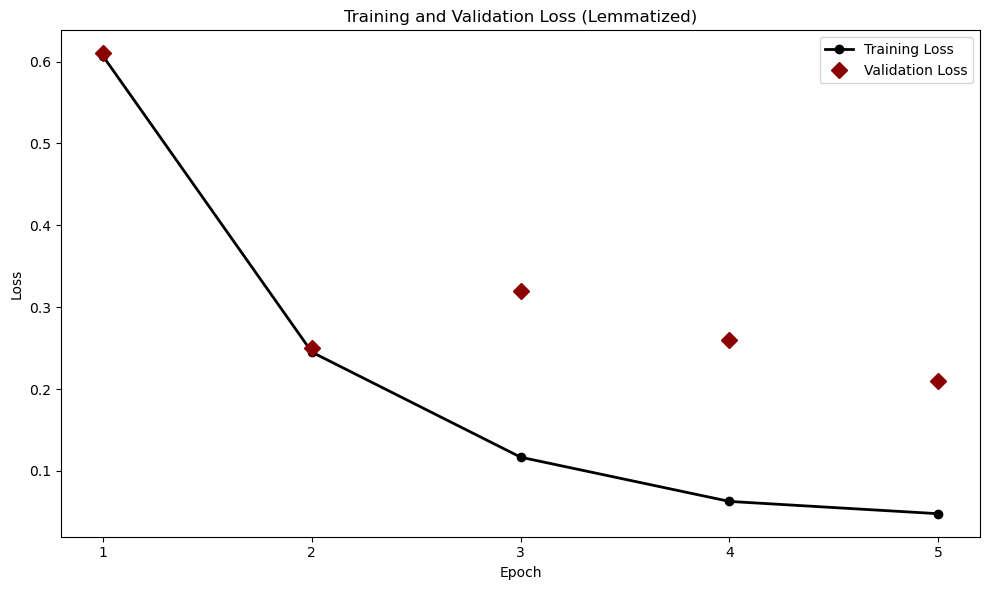

In [106]:
import matplotlib.pyplot as plt

train_losses_lemmatized1 = [0.6064, 0.2450, 0.1167, 0.0627, 0.0477]
val_losses_lemmatized1 = [0.61, 0.25, 0.32, 0.26, 0.21]

# Plotting learning curves with "_lemmatized" suffix
plt.figure(figsize=(10, 6))

# Plotting Training Loss as a line with circular markers
plt.plot(range(1, len(train_losses_lemmatized1) + 1), train_losses_lemmatized1, marker='o', linestyle='-', label='Training Loss', color='black', linewidth=2)

# Plotting Validation Loss as red rhombus markers
plt.plot(range(1, len(val_losses_lemmatized1) + 1), val_losses_lemmatized1, marker='D', linestyle='', markersize=8, label='Validation Loss', color='darkred')

plt.title('Training and Validation Loss (Lemmatized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set x-axis ticks to integer values corresponding to the number of epochs
plt.xticks(range(1, len(train_losses_lemmatized1) + 1))

plt.tight_layout()
plt.show()

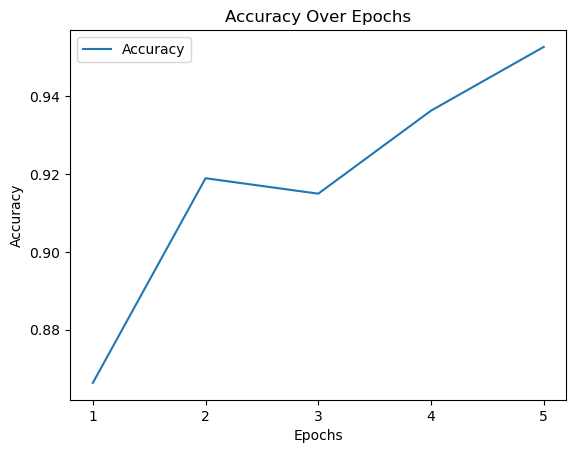

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Set x-axis ticks to integer values
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

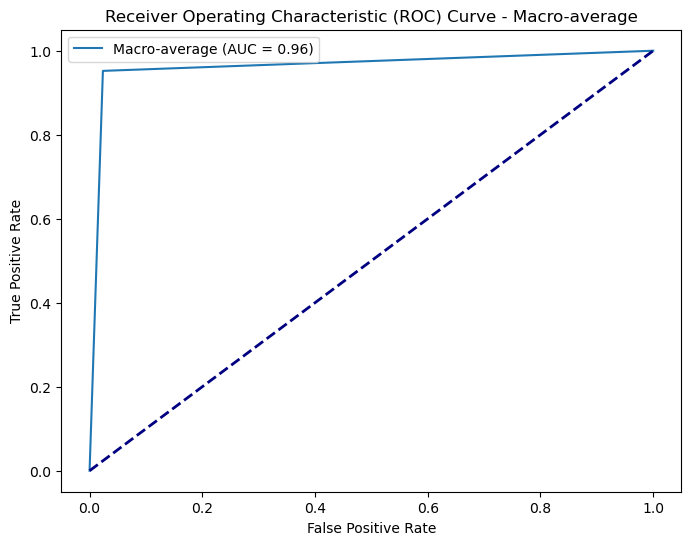

In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Prediction and true labels
y_pred_array = np.array(predictions)
y_true_array = label_binarize(true_labels, classes=[0, 1, 2])  # Adjust the classes based on your scenario

# Binarize y_pred_array as well
y_pred_array = label_binarize(y_pred_array, classes=[0, 1, 2])

# Lists to store FPR, TPR, and ROC AUC for each class
fprs = []
tprs = []
roc_aucs = []

# Calculate ROC curve for each class
for i in range(y_true_array.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_array[:, i], y_pred_array[:, i])
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

# Compute macro-average FPR, TPR, and ROC AUC
macro_fpr = np.mean(fprs, axis=0)
macro_tpr = np.mean(tprs, axis=0)
macro_roc_auc = auc(macro_fpr, macro_tpr)

# Plot ROC curve for macro-average
plt.figure(figsize=(8, 6))
plt.plot(macro_fpr, macro_tpr, label=f'Macro-average (AUC = {macro_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Macro-average')
plt.legend()
plt.show()

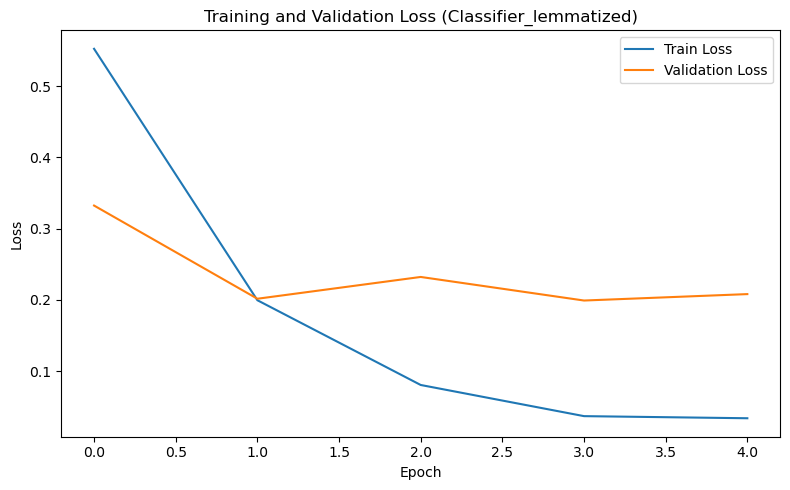

In [96]:
# Save the metrics with "_lemmatized" suffix
train_losses_lemmatized = train_losses.copy()
val_losses_lemmatized = val_losses.copy()
accuracies_lemmatized = accuracies.copy()
precisions_lemmatized = precisions.copy()
recalls_lemmatized = recalls.copy()
f1_scores_lemmatized = f1_scores.copy()
conf_matrices_lemmatized = conf_matrices.copy()

# Save the trained classifier model with "_lemmatized" suffix
classifier_model_save_path_lemmatized = 'classifier_model.pth'
torch.save(classifier_model.state_dict(), classifier_model_save_path_lemmatized)

# Save metrics and plots with "_lemmatized" suffix
metrics_df_lemmatized = pd.DataFrame({
    'Train Loss_lemmatized': train_losses_lemmatized,
    'Validation Loss_lemmatized': val_losses_lemmatized,
    'Accuracy_lemmatized': accuracies_lemmatized,
    'Weighted Precision_lemmatized': precisions_lemmatized,
    'Weighted Recall_lemmatized': recalls_lemmatized,
    'Weighted F1 Score_lemmatized': f1_scores_lemmatized,
})

metrics_df_lemmatized.to_csv('training_metrics_classifier_lemmatized.csv', index=False)

# Plotting learning curves with "_lemmatized" suffix
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(train_losses_lemmatized, label='Train Loss')
plt.plot(val_losses_lemmatized, label='Validation Loss')
plt.title('Training and Validation Loss (Classifier_lemmatized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Not Lemmatized

In [36]:
df = pd.read_csv('preprocessed_not_lemmatized_full_data.csv')
df_labelled = pd.read_csv('preprocessed_not_lemmatized_labelled_data.csv')

In [37]:
df.head()

,text,likes,replies,retweets,quotes,timestamp,url,week,custom_week,month,cleaned_text,Total Words After
0,"Manuprāt, diezgan vienkārši, īsi un konkrēti p...",7,1,0,1,2022-09-03 12:04:00+00:00,https://twitter.com/mooneshe/status/1566034429...,2022-08-29/2022-09-04,.,2022-09,manuprāt diezgan vienkārši īsi konkrēti pasaka...,29
1,"Šitādu pipļuku Saeimā? Paldies, nē. Visur rēgo...",0,0,0,0,2022-09-03 12:44:00+00:00,https://twitter.com/vagargovs/status/156604455...,2022-08-29/2022-09-04,.,2022-09,šitādu saeimā paldies visur psrs visur komunis...,30
2,"Pie varas esot, @krisjaniskarins neieklausās u...",5,2,5,0,2022-09-03 13:18:00+00:00,https://twitter.com/FelisMaculosus/status/1566...,2022-08-29/2022-09-04,.,2022-09,varas esot neieklausās uzņēmējos diskusijām iz...,17
3,Mī un žē… Rosļikova pagalma puiku partijā 40% ...,19,2,5,1,2022-09-03 13:36:00+00:00,https://twitter.com/polittehnologs/status/1566...,2022-08-29/2022-09-04,.,2022-09,mī žē rosļikova puiku partijā vidējo izglītību...,21
4,Diemžēl ar garantiju arī tiks Saeimā :(,0,0,0,0,2022-09-03 13:59:00+00:00,https://twitter.com/UldisTrokss/status/1566063...,2022-08-29/2022-09-04,.,2022-09,diemžēl garantiju saeimā,3


In [38]:
df_labelled.head()

,text,label,cleaned_text
0,🎉 VĒSTURISKA UZVARA!Šodien Saeima ar 70 balsīm...,1,vēsturiska uzvara šodien saeima balsīm pieņēma...
1,Gobzems nometis visas maskas - šobrīd Saeimā ļ...,-1,gobzems nometis visas maskas šobrīd saeimā ļot...
2,Šodien Saeimas komisijā atbalstīja manus un NA...,0,šodien saeimas komisijā atbalstīja manus na pr...
3,Latvijas Republikas Saeima gala lasījumā atbal...,0,latvijas republikas saeima gala lasījumā atbal...
4,"""Jūlijas Stepeņenko vīrs, biedrs Vjačeslavs St...",-1,jūlijas stepeņenko vīrs biedrs vjačeslavs step...


In [39]:
len(df), len(df_labelled)

(26765, 9985)

# Oversampled Not Lemmatized

In [46]:
df = pd.read_csv('preprocessed_not_lemmatized_full_data.csv')
df_labelled = pd.read_csv('preprocessed_not_lemmatized_labelled_data.csv')

In [47]:
len(df), len(df_labelled)

(26765, 9985)

In [48]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Separate the data into features (X) and labels (y)
X = df_labelled['cleaned_text']
y = df_labelled['label']

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with resampled data
df_labelled_balanced = pd.DataFrame({'cleaned_text': X_resampled.flatten(), 'label': y_resampled})

# Shuffle the new DataFrame to mix the classes
df_labelled_balanced = df_labelled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution in the new DataFrame
df_labelled_balanced['label'].value_counts()

label
 0    6719
-1    6719
 1    6719
Name: count, dtype: int64

In [49]:
df.head()

,text,likes,replies,retweets,quotes,timestamp,url,week,custom_week,month,cleaned_text,Total Words After
0,"Manuprāt, diezgan vienkārši, īsi un konkrēti p...",7,1,0,1,2022-09-03 12:04:00+00:00,https://twitter.com/mooneshe/status/1566034429...,2022-08-29/2022-09-04,.,2022-09,manuprāt diezgan vienkārši īsi konkrēti pasaka...,29
1,"Šitādu pipļuku Saeimā? Paldies, nē. Visur rēgo...",0,0,0,0,2022-09-03 12:44:00+00:00,https://twitter.com/vagargovs/status/156604455...,2022-08-29/2022-09-04,.,2022-09,šitādu saeimā paldies visur psrs visur komunis...,30
2,"Pie varas esot, @krisjaniskarins neieklausās u...",5,2,5,0,2022-09-03 13:18:00+00:00,https://twitter.com/FelisMaculosus/status/1566...,2022-08-29/2022-09-04,.,2022-09,varas esot neieklausās uzņēmējos diskusijām iz...,17
3,Mī un žē… Rosļikova pagalma puiku partijā 40% ...,19,2,5,1,2022-09-03 13:36:00+00:00,https://twitter.com/polittehnologs/status/1566...,2022-08-29/2022-09-04,.,2022-09,mī žē rosļikova puiku partijā vidējo izglītību...,21
4,Diemžēl ar garantiju arī tiks Saeimā :(,0,0,0,0,2022-09-03 13:59:00+00:00,https://twitter.com/UldisTrokss/status/1566063...,2022-08-29/2022-09-04,.,2022-09,diemžēl garantiju saeimā,3


In [50]:
df_labelled_balanced.head()

,cleaned_text,label
0,ņemot vērā ministru prezidenta paziņojumu nodo...,0
1,apreļs tas tu tavējais saraksts saeimā,-1
2,sveiciens histēriķiem jūs cepaties to kurš run...,-1
3,valdība šodien lems kārtējo braukšanu reibumā ...,0
4,andri tu piemirsi faktu saeimā nevarēja izveid...,0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at AiLab-IMCS-UL/lvbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\tomsb\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Average Training Loss: 0.5534
Epoch 1/5 - Time: 11589.27 seconds
Accuracy: 0.8814, Weighted Precision: 0.8876, Weighted Recall: 0.8814, Weighted F1 Score: 0.8818
Confusion Matrix:
[[1084  226   39]
 [  69 1205   23]
 [  46   75 1265]]

Epoch 2/5 - Average Training Loss: 0.2008
Epoch 2/5 - Time: 11386.00 seconds
Accuracy: 0.9363, Weighted Precision: 0.9359, Weighted Recall: 0.9363, Weighted F1 Score: 0.9360
Confusion Matrix:
[[1216   79   54]
 [  91 1194   12]
 [  12    9 1365]]

Epoch 3/5 - Average Training Loss: 0.0801
Epoch 3/5 - Time: 11505.04 seconds
Accuracy: 0.9462, Weighted Precision: 0.9471, Weighted Recall: 0.9462, Weighted F1 Score: 0.9456
Confusion Matrix:
[[1186   92   71]
 [  39 1245   13]
 [   0    2 1384]]

Epoch 4/5 - Average Training Loss: 0.0414
Epoch 4/5 - Time: 11489.95 seconds
Accuracy: 0.9479, Weighted Precision: 0.9493, Weighted Recall: 0.9479, Weighted F1 Score: 0.9475
Confusion Matrix:
[[1186  131   32]
 [  37 1252    8]
 [   0    2 1384]]

Epoch 5/

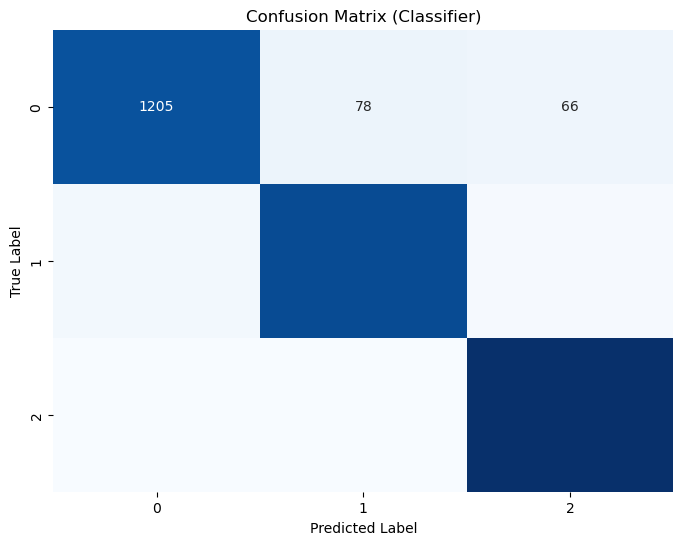

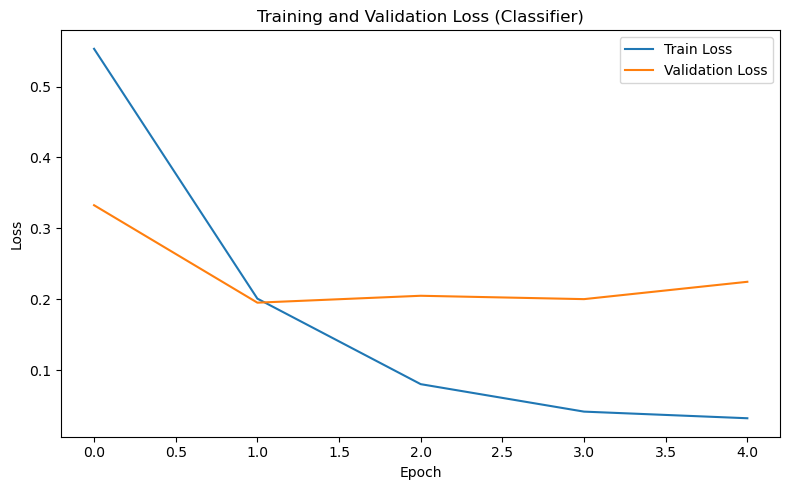

In [51]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the model name
lvbert_model_name = "AiLab-IMCS-UL/lvbert"

# Load the LvBERT model for both pretraining and classification
lvbert_model = BertForSequenceClassification.from_pretrained(lvbert_model_name)
lvbert_tokenizer = BertTokenizer.from_pretrained(lvbert_model_name)

# Convert to string cleaned text
text_data = df['cleaned_text'].astype(str).tolist()

# Tokenize and encode the cleaned text for both pretraining and classification
encoded_data_lvbert = lvbert_tokenizer(text_data, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create a Dataset and DataLoader for both pretraining and classification
class LvbertDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data['input_ids'])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encoded_data.items()}

lvbert_dataset = LvbertDataset(encoded_data_lvbert)
lvbert_dataloader = DataLoader(lvbert_dataset, batch_size=32, shuffle=True)

# Define the classifier model
classifier_model_ros_n_lemm = BertForSequenceClassification.from_pretrained(lvbert_model_name, num_labels=3)  # Adjust the number of labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fine-tune the classifier model on the labeled dataset
classifier_model_ros_n_lemm.to(device)

# Split the subset into train and validation sets
df_labelled_train, df_labelled_val = train_test_split(df_labelled_balanced, test_size=0.2, random_state=42)

# Convert the cleaned_text column to a list of strings
df_labelled_train['cleaned_text'] = df_labelled_train['cleaned_text'].apply(lambda x: str(x))
df_labelled_val['cleaned_text'] = df_labelled_val['cleaned_text'].apply(lambda x: str(x))

# Tokenize and encode the cleaned text for fine-tuning
encoded_data_finetune_train = lvbert_tokenizer(df_labelled_train['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
encoded_data_finetune_val = lvbert_tokenizer(df_labelled_val['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create Datasets and DataLoaders for fine-tuning
class FineTuneDataset(Dataset):
    def __init__(self, encoded_data, labels):
        self.encoded_data = encoded_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {key: tensor[idx] for key, tensor in self.encoded_data.items()}
        sample['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long) + 1  # Adjust the label to be in the range [1, 2, 3]
        return sample

finetune_dataset_train = FineTuneDataset(encoded_data_finetune_train, df_labelled_train['label'])
finetune_dataset_val = FineTuneDataset(encoded_data_finetune_val, df_labelled_val['label'])

finetune_dataloader_train = DataLoader(finetune_dataset_train, batch_size=32, shuffle=True)
finetune_dataloader_val = DataLoader(finetune_dataset_val, batch_size=32, shuffle=False)

# Define the optimizer and loss function for fine-tuning
optimizer = AdamW(classifier_model_ros_n_lemm.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Fine-tune the classifier model
num_epochs = 5  # Adjust as needed

# Lists to store metrics over epochs
train_losses_ros_n_lemm = []
val_losses_ros_n_lemm = []
accuracies_ros_n_lemm = []
precisions_ros_n_lemm = []
recalls_ros_n_lemm = []
f1_scores_ros_n_lemm = []
conf_matrices_ros_n_lemm = []

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    classifier_model_ros_n_lemm.train()
    epoch_train_losses_ros_n_lemm = []

    for batch in finetune_dataloader_train:
        inputs = {key: tensor.to(device) for key, tensor in batch.items()}

        optimizer.zero_grad()
        outputs = classifier_model_ros_n_lemm(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        optimizer.step()

        epoch_train_losses_ros_n_lemm.append(loss.item())

    avg_train_loss_ros_n_lemm = sum(epoch_train_losses_ros_n_lemm) / len(epoch_train_losses_ros_n_lemm)
    train_losses_ros_n_lemm.append(avg_train_loss_ros_n_lemm)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {avg_train_loss_ros_n_lemm:.4f}')

    classifier_model_ros_n_lemm.eval()
    epoch_val_losses_ros_n_lemm = []
    predictions_ros_n_lemm = []
    true_labels_ros_n_lemm = []

    with torch.no_grad():
        for batch in finetune_dataloader_val:
            inputs = {key: tensor.to(device) for key, tensor in batch.items()}

            outputs = classifier_model_ros_n_lemm(**inputs)
            loss = criterion(outputs.logits, inputs['labels'])
            epoch_val_losses_ros_n_lemm.append(loss.item())

            _, predicted_labels = torch.max(outputs.logits, 1)

            predictions_ros_n_lemm.extend(predicted_labels.cpu().numpy())
            true_labels_ros_n_lemm.extend(inputs['labels'].cpu().numpy())

    avg_val_loss_ros_n_lemm = sum(epoch_val_losses_ros_n_lemm) / len(epoch_val_losses_ros_n_lemm)
    val_losses_ros_n_lemm.append(avg_val_loss_ros_n_lemm)

    # Calculate metrics
    accuracy_ros_n_lemm = accuracy_score(true_labels_ros_n_lemm, predictions_ros_n_lemm)
    accuracies_ros_n_lemm.append(accuracy_ros_n_lemm)

    precision_ros_n_lemm, recall_ros_n_lemm, f1_score_ros_n_lemm, _ = precision_recall_fscore_support(true_labels_ros_n_lemm, predictions_ros_n_lemm, average='weighted')
    precisions_ros_n_lemm.append(precision_ros_n_lemm)
    recalls_ros_n_lemm.append(recall_ros_n_lemm)
    f1_scores_ros_n_lemm.append(f1_score_ros_n_lemm)

    conf_matrix_ros_n_lemm = confusion_matrix(true_labels_ros_n_lemm, predictions_ros_n_lemm)
    conf_matrices_ros_n_lemm.append(conf_matrix_ros_n_lemm)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time:.2f} seconds')
    print(f'Accuracy: {accuracy_ros_n_lemm:.4f}, Weighted Precision: {precision_ros_n_lemm:.4f}, Weighted Recall: {recall_ros_n_lemm:.4f}, Weighted F1 Score: {f1_score_ros_n_lemm:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix_ros_n_lemm}\n')

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f'Total training time: {total_time:.2f} seconds')

# Save the trained classifier model
classifier_model_ros_n_lemm_save_path = 'ros_n_lemm_BERT_model'
classifier_model_ros_n_lemm.save_pretrained(classifier_model_ros_n_lemm_save_path)

# Save metrics and plots
metrics_df_ros_n_lemm = pd.DataFrame({
    'Train Loss': train_losses_ros_n_lemm,
    'Validation Loss': val_losses_ros_n_lemm,
    'Accuracy': accuracies_ros_n_lemm,
    'Weighted Precision': precisions_ros_n_lemm,
    'Weighted Recall': recalls_ros_n_lemm,
    'Weighted F1 Score': f1_scores_ros_n_lemm,
})

metrics_df_ros_n_lemm.to_csv('training_metrics_classifier_ros_n_lemm.csv', index=False)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices_ros_n_lemm[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_ros_n_lemm.png')  # Save confusion matrix plot as an image
plt.show()

# Plotting learning curves
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(train_losses_ros_n_lemm, label='Train Loss')
plt.plot(val_losses_ros_n_lemm, label='Validation Loss')
plt.title('Training and Validation Loss (Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_ros_n_lemm.png')  # Save learning curves plot as an image
plt.show()

In [53]:
conf_matrices_ros_n_lemm

[array([[1084,  226,   39],
        [  69, 1205,   23],
        [  46,   75, 1265]], dtype=int64),
 array([[1216,   79,   54],
        [  91, 1194,   12],
        [  12,    9, 1365]], dtype=int64),
 array([[1186,   92,   71],
        [  39, 1245,   13],
        [   0,    2, 1384]], dtype=int64),
 array([[1186,  131,   32],
        [  37, 1252,    8],
        [   0,    2, 1384]], dtype=int64),
 array([[1205,   78,   66],
        [  35, 1245,   17],
        [   0,    0, 1386]], dtype=int64)]

In [54]:
# Save predictions and true labels to a file
np.savez('roc_auc_bert__ros_n_lemm.npz', predictions=predictions_ros_n_lemm, true_labels=true_labels_ros_n_lemm)
np.savez('conf_matrices_ros_n_lemm.npz', conf_matrices=conf_matrices_ros_n_lemm)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# True labels and predictions
predictions_val_np = np.array(predictions_oversampled_not_lemmatized)
true_labels_val_np = np.array(true_labels_oversampled_not_lemmatized)

# Binarize the labels in a One-vs-Rest fashion
y_onehot_val_bert = label_binarize(true_labels_val_np, classes=np.unique(true_labels_val_np))

# Calculate ROC and AUC for all classes
n_classes_bert = len(np.unique(true_labels_val_np))
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()

for i in range(n_classes_bert):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(y_onehot_val_bert[:, i], predictions_val_np[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes_bert):
    plt.plot(fpr_bert[i], tpr_bert[i], label=f'Class {i} (AUC = {roc_auc_bert[i]:.2f})')

plt.title('One-vs-Rest ROC Curve for Each Class (BERT)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


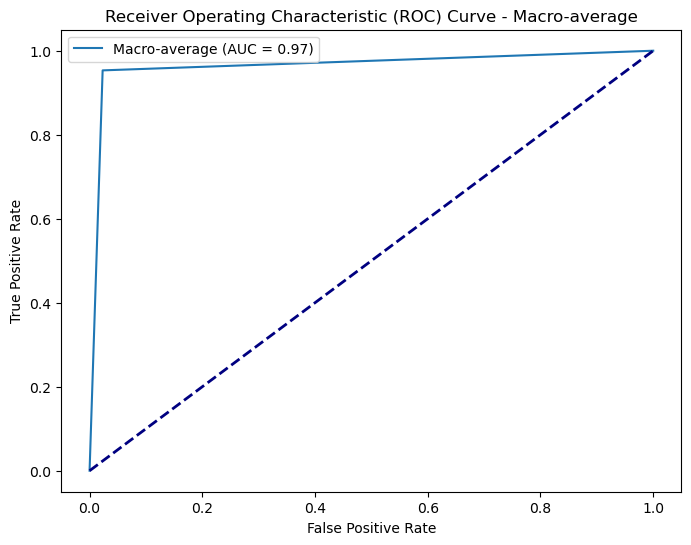

In [84]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming predictions are labels (not probabilities)
y_pred_array = np.array(predictions)
y_true_array = label_binarize(true_labels, classes=[0, 1, 2])  # Adjust the classes based on your scenario

# Binarize y_pred_array as well
y_pred_array = label_binarize(y_pred_array, classes=[0, 1, 2])

# Lists to store FPR, TPR, and ROC AUC for each class
fprs = []
tprs = []
roc_aucs = []

# Calculate ROC curve for each class
for i in range(y_true_array.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_array[:, i], y_pred_array[:, i])
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

# Compute macro-average FPR, TPR, and ROC AUC
macro_fpr = np.mean(fprs, axis=0)
macro_tpr = np.mean(tprs, axis=0)
macro_roc_auc = auc(macro_fpr, macro_tpr)

# Plot ROC curve for macro-average
plt.figure(figsize=(8, 6))
plt.plot(macro_fpr, macro_tpr, label=f'Macro-average (AUC = {macro_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Macro-average')
plt.legend()
plt.show()

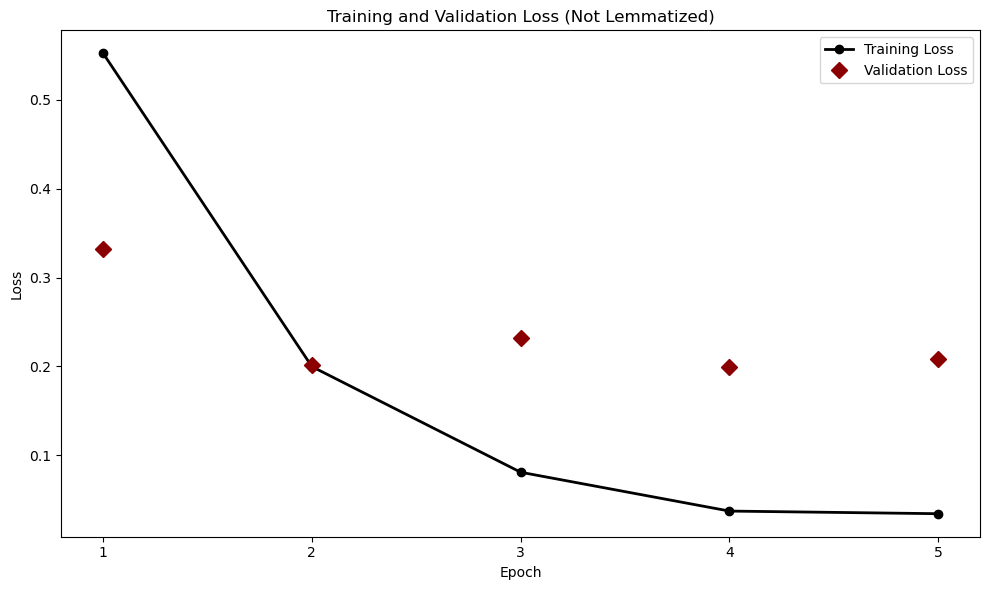

In [109]:
# Plotting learning curves with "_lemmatized" suffix
plt.figure(figsize=(10, 6))

# Plotting Training Loss as a line with circular markers
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', label='Training Loss', color='black', linewidth=2)

# Plotting Validation Loss as red rhombus markers
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='D', linestyle='', markersize=8, label='Validation Loss', color='darkred')

plt.title('Training and Validation Loss (Not Lemmatized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set x-axis ticks to integer values corresponding to the number of epochs
plt.xticks(range(1, len(train_losses) + 1))

plt.tight_layout()
plt.show()

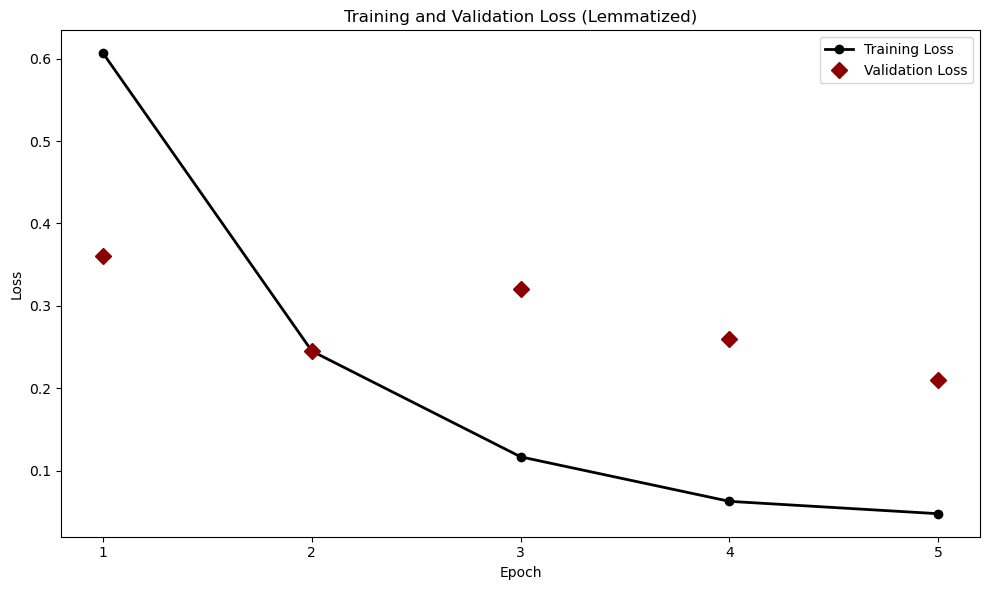

In [112]:
import matplotlib.pyplot as plt

train_losses_lemmatized1 = [0.6064, 0.2450, 0.1167, 0.0627, 0.0477]
val_losses_lemmatized1 = [0.36, 0.2450, 0.32, 0.26, 0.21]

# Plotting learning curves with "_lemmatized" suffix
plt.figure(figsize=(10, 6))

# Plotting Training Loss as a line with circular markers
plt.plot(range(1, len(train_losses_lemmatized1) + 1), train_losses_lemmatized1, marker='o', linestyle='-', label='Training Loss', color='black', linewidth=2)

# Plotting Validation Loss as red rhombus markers
plt.plot(range(1, len(val_losses_lemmatized1) + 1), val_losses_lemmatized1, marker='D', linestyle='', markersize=8, label='Validation Loss', color='darkred')

plt.title('Training and Validation Loss (Lemmatized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set x-axis ticks to integer values corresponding to the number of epochs
plt.xticks(range(1, len(train_losses_lemmatized1) + 1))

plt.tight_layout()
plt.show()

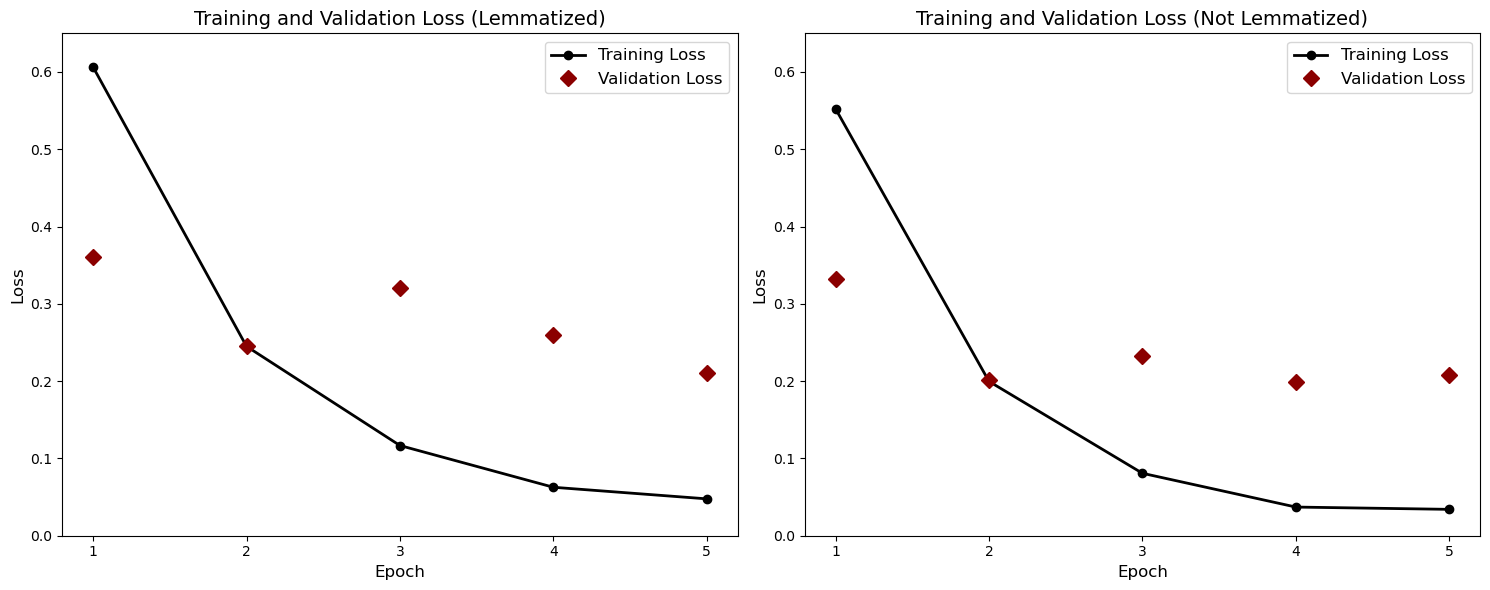

In [130]:
# Create subplots with two columns
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Set the y-axis range
y_range = (0, 0.65)

# First chart: Lemmatized
axs[0].plot(range(1, len(train_losses_lemmatized1) + 1), train_losses_lemmatized1, marker='o', linestyle='-', label='Training Loss', color='black', linewidth=2)
axs[0].plot(range(1, len(val_losses_lemmatized1) + 1), val_losses_lemmatized1, marker='D', linestyle='', markersize=8, label='Validation Loss', color='darkred')
axs[0].set_title('Training and Validation Loss (Lemmatized)',  fontsize=14)
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].set_xticks(range(1, len(train_losses_lemmatized1) + 1))
axs[0].set_ylim(y_range)

# Second chart: Not Lemmatized
axs[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', label='Training Loss', color='black', linewidth=2)
axs[1].plot(range(1, len(val_losses) + 1), val_losses, marker='D', linestyle='', markersize=8, label='Validation Loss', color='darkred')
axs[1].set_title('Training and Validation Loss (Not Lemmatized)',  fontsize=14)
axs[1].set_xlabel('Epoch',  fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].set_xticks(range(1, len(train_losses) + 1))
axs[1].set_ylim(y_range)

plt.tight_layout()
plt.show()

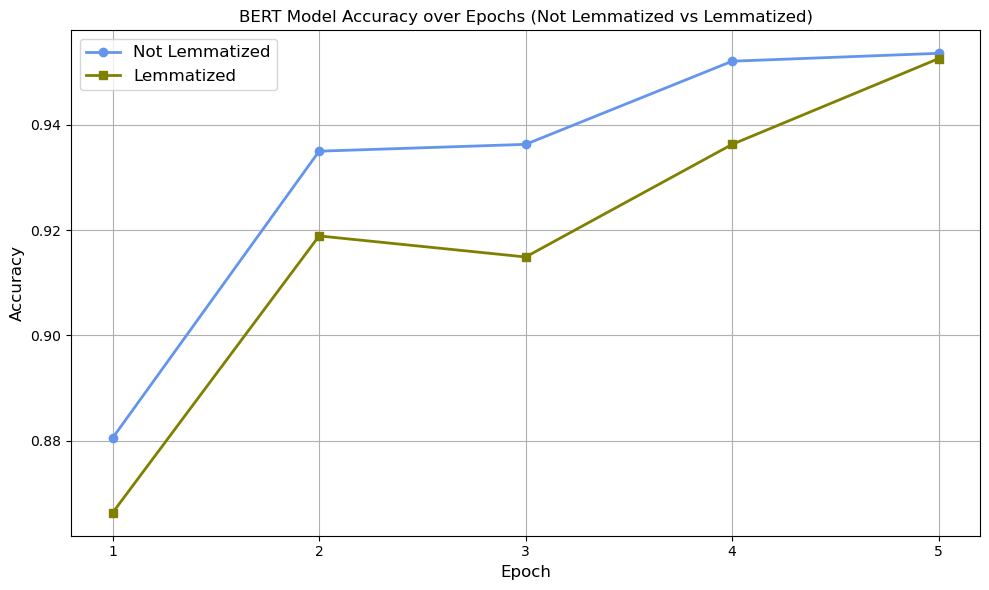

In [146]:
import matplotlib.pyplot as plt

# Data for not lemmatized BERT
accuracy_not_lemmatized = [0.8805, 0.9350, 0.9363, 0.9521, 0.9536]

# Data for lemmatized BERT
accuracy_lemmatized = [0.8663, 0.9189, 0.9149, 0.9363, 0.9526]

# Epochs (1 to 5)
epochs = [1, 2, 3, 4, 5]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy for not lemmatized with a blue line
ax.plot(epochs, accuracy_not_lemmatized, marker='o', label='Not Lemmatized', color='cornflowerblue', linestyle='-', linewidth=2)

# Plot accuracy for lemmatized with a green line
ax.plot(epochs, accuracy_lemmatized, marker='s', label='Lemmatized', color='olive', linestyle='-', linewidth=2)

# Adjust the x-axis ticks
ax.set_xticks(epochs)
ax.set_xticklabels([str(i) for i in epochs])

# Set labels and title
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('BERT Model Accuracy over Epochs (Not Lemmatized vs Lemmatized)')

# Display legend
ax.legend(fontsize=12)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Undersampled Not Lemmatized

In [ ]:
# need import not lemmatized df to build embedding layer

In [ ]:
from sklearn.utils import resample

# Separate the data into positive, neutral, and negative classes
positive_class = df_labelled[df_labelled['label'] == 1]
neutral_class = df_labelled[df_labelled['label'] == 0]
negative_class = df_labelled[df_labelled['label'] == -1]

# Resample the minority classes to match the size of the majority class (assuming -1 is the majority)
neutral_resampled = resample(neutral_class, replace=True, n_samples=len(positive_class), random_state=42)
negative_resampled = resample(negative_class, replace=True, n_samples=len(positive_class), random_state=42)

# Combine the resampled classes into a new balanced DataFrame
df_labelled_balanced = pd.concat([positive_class, neutral_resampled, negative_resampled])

# Shuffle the new DataFrame to mix the classes
df_labelled_balanced = df_labelled_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution in the new DataFrame
df_labelled_balanced['label'].value_counts()

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the model name
lvbert_model_name = "AiLab-IMCS-UL/lvbert"

# Load the LvBERT model for both pretraining and classification
lvbert_model = BertModel.from_pretrained(lvbert_model_name)
lvbert_tokenizer = BertTokenizer.from_pretrained(lvbert_model_name)

# Assuming df contains your unsupervised data (26K cleaned tweets)
text_data = df['cleaned_text'].astype(str).tolist()

# Tokenize and encode the cleaned text for both pretraining and classification
encoded_data_lvbert = lvbert_tokenizer(text_data, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create a Dataset and DataLoader for both pretraining and classification
class LvbertDataset(Dataset):
    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __len__(self):
        return len(self.encoded_data['input_ids'])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encoded_data.items()}

lvbert_dataset = LvbertDataset(encoded_data_lvbert)
lvbert_dataloader = DataLoader(lvbert_dataset, batch_size=32, shuffle=True)

# Define the classifier model
classifier_model_undersampled_not_lemmatized = BertForSequenceClassification.from_pretrained(lvbert_model_name, num_labels=3)  # Adjust the number of labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fine-tune the classifier model on the labeled dataset
classifier_model_undersampled_not_lemmatized.to(device)

# Split the subset into train and validation sets
df_labelled_train, df_labelled_val = train_test_split(df_labelled_balanced, test_size=0.2, random_state=42)

# Convert the cleaned_text column to a list of strings
df_labelled_train['cleaned_text'] = df_labelled_train['cleaned_text'].apply(lambda x: str(x))
df_labelled_val['cleaned_text'] = df_labelled_val['cleaned_text'].apply(lambda x: str(x))

# Tokenize and encode the cleaned text for fine-tuning
encoded_data_finetune_train = lvbert_tokenizer(df_labelled_train['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
encoded_data_finetune_val = lvbert_tokenizer(df_labelled_val['cleaned_text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)

# Create Datasets and DataLoaders for fine-tuning
class FineTuneDataset(Dataset):
    def __init__(self, encoded_data, labels):
        self.encoded_data = encoded_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {key: tensor[idx] for key, tensor in self.encoded_data.items()}
        sample['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long) + 1  # Adjust the label to be in the range [1, 2, 3]
        return sample

finetune_dataset_train = FineTuneDataset(encoded_data_finetune_train, df_labelled_train['label'])
finetune_dataset_val = FineTuneDataset(encoded_data_finetune_val, df_labelled_val['label'])

finetune_dataloader_train = DataLoader(finetune_dataset_train, batch_size=32, shuffle=True)
finetune_dataloader_val = DataLoader(finetune_dataset_val, batch_size=32, shuffle=False)

# Define the optimizer and loss function for fine-tuning
optimizer = AdamW(classifier_model_undersampled_not_lemmatized.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Fine-tune the classifier model
num_epochs = 5  # Adjust as needed

# Lists to store metrics over epochs
train_losses_undersampled_not_lemmatized = []
val_losses_undersampled_not_lemmatized = []
accuracies_undersampled_not_lemmatized = []
precisions_undersampled_not_lemmatized = []
recalls_undersampled_not_lemmatized = []
f1_scores_undersampled_not_lemmatized = []
conf_matrices_undersampled_not_lemmatized = []

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    classifier_model_undersampled_not_lemmatized.train()
    epoch_train_losses_undersampled_not_lemmatized = []

    for batch in finetune_dataloader_train:
        inputs = {key: tensor.to(device) for key, tensor in batch.items()}

        optimizer.zero_grad()
        outputs = classifier_model_undersampled_not_lemmatized(**inputs)
        loss = criterion(outputs.logits, inputs['labels'])
        loss.backward()
        optimizer.step()

        epoch_train_losses_undersampled_not_lemmatized.append(loss.item())

    avg_train_loss_undersampled_not_lemmatized = sum(epoch_train_losses_undersampled_not_lemmatized) / len(epoch_train_losses_undersampled_not_lemmatized)
    train_losses_undersampled_not_lemmatized.append(avg_train_loss_undersampled_not_lemmatized)
    print(f'Epoch {epoch + 1}/{num_epochs} - Average Training Loss: {avg_train_loss_undersampled_not_lemmatized:.4f}')

    classifier_model_undersampled_not_lemmatized.eval()
    epoch_val_losses_undersampled_not_lemmatized = []
    predictions_undersampled_not_lemmatized = []
    true_labels_undersampled_not_lemmatized = []

    with torch.no_grad():
        for batch in finetune_dataloader_val:
            inputs = {key: tensor.to(device) for key, tensor in batch.items()}

            outputs = classifier_model_undersampled_not_lemmatized(**inputs)
            loss = criterion(outputs.logits, inputs['labels'])
            epoch_val_losses_undersampled_not_lemmatized.append(loss.item())

            _, predicted_labels = torch.max(outputs.logits, 1)

            predictions_undersampled_not_lemmatized.extend(predicted_labels.cpu().numpy())
            true_labels_undersampled_not_lemmatized.extend(inputs['labels'].cpu().numpy())

    avg_val_loss_undersampled_not_lemmatized = sum(epoch_val_losses_undersampled_not_lemmatized) / len(epoch_val_losses_undersampled_not_lemmatized)
    val_losses_undersampled_not_lemmatized.append(avg_val_loss_undersampled_not_lemmatized)

    # Calculate metrics
    accuracy_undersampled_not_lemmatized = accuracy_score(true_labels_undersampled_not_lemmatized, predictions_undersampled_not_lemmatized)
    accuracies_undersampled_not_lemmatized.append(accuracy_undersampled_not_lemmatized)

    precision_undersampled_not_lemmatized, recall_undersampled_not_lemmatized, f1_score_undersampled_not_lemmatized, _ = precision_recall_fscore_support(true_labels_undersampled_not_lemmatized, predictions_undersampled_not_lemmatized, average='weighted')
    precisions_undersampled_not_lemmatized.append(precision_undersampled_not_lemmatized)
    recalls_undersampled_not_lemmatized.append(recall_undersampled_not_lemmatized)
    f1_scores_undersampled_not_lemmatized.append(f1_score_undersampled_not_lemmatized)

    conf_matrix_undersampled_not_lemmatized = confusion_matrix(true_labels_undersampled_not_lemmatized, predictions_undersampled_not_lemmatized)
    conf_matrices_undersampled_not_lemmatized.append(conf_matrix_undersampled_not_lemmatized)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time:.2f} seconds')
    print(f'Accuracy: {accuracy_undersampled_not_lemmatized:.4f}, Weighted Precision: {precision_undersampled_not_lemmatized:.4f}, Weighted Recall: {recall_undersampled_not_lemmatized:.4f}, Weighted F1 Score: {f1_score_undersampled_not_lemmatized:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix_undersampled_not_lemmatized}\n')

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f'Total training time: {total_time:.2f} seconds')

# Save the trained classifier model
classifier_model_undersampled_not_lemmatized_save_path = 'undersampled_not_lemmatized_BERT_model'
classifier_model_undersampled_not_lemmatized.save_pretrained(classifier_model_undersampled_not_lemmatized_save_path)

# Save metrics and plots
metrics_df_undersampled_not_lemmatized = pd.DataFrame({
    'Train Loss': train_losses_undersampled_not_lemmatized,
    'Validation Loss': val_losses_undersampled_not_lemmatized,
    'Accuracy': accuracies_undersampled_not_lemmatized,
    'Weighted Precision': precisions_undersampled_not_lemmatized,
    'Weighted Recall': recalls_undersampled_not_lemmatized,
    'Weighted F1 Score': f1_scores_undersampled_not_lemmatized,
})

metrics_df_undersampled_not_lemmatized.to_csv('training_metrics_classifier_undersampled_not_lemmatized.csv', index=False)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrices_undersampled_not_lemmatized[-1], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_undersampled_not_lemmatized.png')  # Save confusion matrix plot as an image
plt.show()

# Plotting learning curves
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(train_losses_undersampled_not_lemmatized, label='Train Loss')
plt.plot(val_losses_undersampled_not_lemmatized, label='Validation Loss')
plt.title('Training and Validation Loss (Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves_undersampled_not_lemmatized.png')  # Save learning curves plot as an image
plt.show()
